In [19]:
from transformer import *
from utils import *
import tensorflow as tf
import numpy
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from jiwer import wer as jwer
import seaborn as sns

In [38]:
class parameters():
    number_sentence = 3
    num_layers = 4
    d_model = 90
    dff = 1024
    num_heads = 15
    input_vocab_size = 0
    target_vocab_size = 0
    dropout_rate = 0.1
    freq = 100
    feature = 1
    data = 'eeg'
    seed = 1234
    n_batches = 10
    epochs = 50

In [39]:
"""
Get dataset and parameters
"""
tf.random.set_seed(params.seed*3)
params = parameters()
input_set, target_set, seq_len_set, original_set = load_data(params)
input_set, _ = pad_sequences(input_set, dtype=np.float32)
target_set, _ = pad_sequences(target_set, dtype=np.int64)
params.d_model = input_set.shape[-1]
params.target_vocab_size = len(params.dictionary)+1
params.max_length = len(target_set[0])
x_train, x_test, y_train, y_test = train_test_split(input_set, target_set, test_size = 0.1, random_state = 42)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(
    8192, seed=params.seed).batch(1)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(
    8192, seed=params.seed).batch(params.n_batches)
"""
    Define loss, model, optimizer
"""
learning_rate = CustomSchedule(params.d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

transformer = Transformer(
    num_layers=params.num_layers,
    d_model=params.d_model, num_heads=params.num_heads,
    dff=params.dff, target_vocab_size=params.target_vocab_size,
    pe_target=6000)
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print('Latest checkpoint restored!!')
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.



@tf.function
def train_step(inp,tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    # enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    combined_mask = create_combined_mask(tar=tar_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                     True,
                                     None,
                                     combined_mask,
                                     None)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

for epoch in range(params.epochs):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

    if batch % 50 == 0:
        print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
            epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1,
                                                            ckpt_save_path))

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                        train_loss.result(),
                                                        train_accuracy.result()))

    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
"""
    Evaluation + Test
"""
params.transformer = transformer
ground_truth = []
predicted = []
wer = None
for inp,tar in test_dataset:
    gtruth, pred = translate(inp,tar, params)
    ground_truth.append(gtruth)
    predicted.append(pred)
wer = jwer(ground_truth,predicted)
print("word error rate : {}".format(wer))

Epoch 1 Loss 2.9318 Accuracy 0.0425
Time taken for 1 epoch: 11.490718603134155 secs

Epoch 2 Loss 2.8199 Accuracy 0.0370
Time taken for 1 epoch: 0.4861319065093994 secs

Epoch 3 Loss 2.7652 Accuracy 0.0562
Time taken for 1 epoch: 0.4659585952758789 secs

Epoch 4 Loss 2.5950 Accuracy 0.0864
Time taken for 1 epoch: 0.466991662979126 secs

Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-1
Epoch 5 Loss 2.5217 Accuracy 0.0919
Time taken for 1 epoch: 0.5674004554748535 secs

Epoch 6 Loss 2.4649 Accuracy 0.1015
Time taken for 1 epoch: 0.4700891971588135 secs

Epoch 7 Loss 2.3749 Accuracy 0.1070
Time taken for 1 epoch: 0.46474504470825195 secs

Epoch 8 Loss 2.3954 Accuracy 0.1070
Time taken for 1 epoch: 0.467937707901001 secs

Epoch 9 Loss 2.3768 Accuracy 0.1111
Time taken for 1 epoch: 0.5059235095977783 secs

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Epoch 10 Loss 2.1821 Accuracy 0.1221
Time taken for 1 epoch: 0.610997200012207 secs

Epoch 11 Loss 2.1095 Accuracy 

In [40]:
result, attention_weights = evaluate(inp, params)

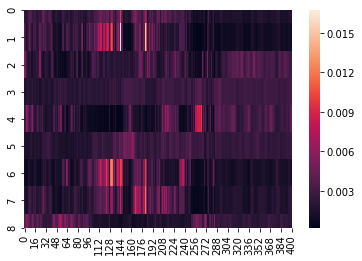

In [62]:
sns.heatmap(plt_attention[-1])

In [63]:
plt_attention[0]

<tf.Tensor: id=978564, shape=(9, 401), dtype=float32, numpy=
array([[0.00987084, 0.01421907, 0.02354365, ..., 0.002192  , 0.00193815,
        0.00170565],
       [0.00121806, 0.00130758, 0.00119886, ..., 0.00362049, 0.00318133,
        0.00266814],
       [0.00290146, 0.00214626, 0.00164911, ..., 0.0036106 , 0.00339971,
        0.00325827],
       ...,
       [0.00314942, 0.00332866, 0.00353705, ..., 0.00171343, 0.00176125,
        0.00180163],
       [0.00085413, 0.00136441, 0.00291556, ..., 0.0005576 , 0.00052905,
        0.00047886],
       [0.00389475, 0.00247717, 0.00386589, ..., 0.00287018, 0.00240047,
        0.00196554]], dtype=float32)>

Text(0.5, 69.0, 'Predicted word')

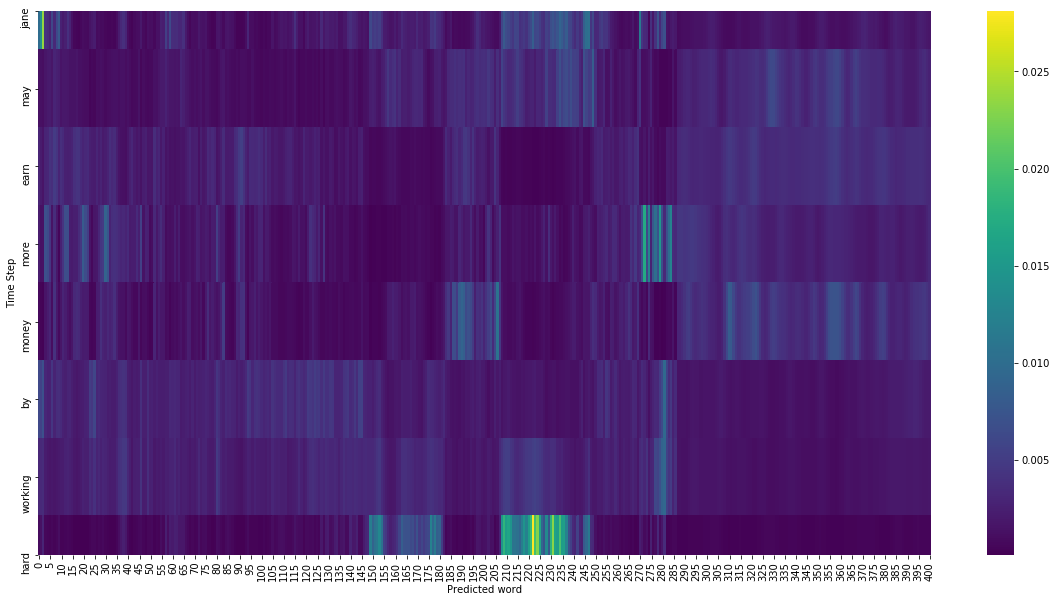

In [54]:
p,ax = plt.subplots(figsize=(20, 10))
plt_attention =tf.squeeze(attention_weights['decoder_layer4_block2'],axis=0)
ax = sns.heatmap(plt_attention[0][:-1,:],cmap='viridis',
                yticklabels='jane may earn more money by working hard'.split(' '))
ax.set_ylabel("Time Step")
ax.set_xlabel("Predicted word")

In [16]:
ax = sns.heatmap(plot[139*3+2][:8].T[:210],xticklabels=sentence[139*3+2].split(' ')[1:-2])
ax.set_ylabel("Time Step")
ax.set_xlabel("Predicted word")

{'decoder_layer1_block1': <tf.Tensor: id=194464, shape=(1, 15, 9, 9), dtype=float32, numpy=
 array([[[[1.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.48806918, 0.5119308 , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.30592245, 0.3536501 , 0.34042746, ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.18392654, 0.16937542, 0.12059807, ..., 0.106235  ,
           0.        , 0.        ],
          [0.14497459, 0.15900429, 0.1246492 , ..., 0.09891009,
           0.07968421, 0.        ],
          [0.10428701, 0.10375456, 0.12316876, ..., 0.11728459,
           0.08061224, 0.05126862]],
 
         [[1.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.5092278 , 0.49077216, 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.30765373, 0.23757885, 0.45476747, ..., 0.        ,
           0.        , 0. 